In [2]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
from sklearn.model_selection import train_test_split

from scipy.stats import chisquare

In [3]:
TrainingColums    = { "kpi"  : ["nTracks","B_P","gamma_PT","Kst_892_0_PT","B_Cone3_B_ptasy","B_ETA"],
                      "pipi" : ["nTracks","B_P","gamma_PT","rho_770_0_PT","B_Cone3_B_ptasy","B_ETA"]}


sharedColums = ["nTracks","B_P","gamma_PT","B_Cone3_B_ptasy", 
                "B_ETA", "B_MINIPCHI2","B_SmallestDeltaChi2OneTrack",
                "B_FD_OWNPV","piminus_PT", "piminus_IP_OWNPV"]


columns    = {"kpi"  : sharedColums + ["Kst_892_0_PT","Kst_892_0_IP_OWNPV","Kplus_PT", "Kplus_IP_OWNPV" ],
              "pipi" : sharedColums + ["rho_770_0_PT","rho_770_0_IP_OWNPV","piplus_PT","piplus_IP_OWNPV"]}


modes      = ["kpi","kpisw", "pipi"]
hist_style = {"bins" : 50, "density" : True, "alpha" : 1, "histtype" : "step"}
colors     = {"blue" : "#066bd6", "red" : "#d60645",  "pink" : "#2fad66", "green":"#2fad66","black":"#000000"}

In [4]:
dataframes  = {}
path = "/Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/"

# Imports the Kpi monte carlo data - Original
with uproot.open(path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel.root") as Kpi_TChain_MC: # type: ignore
    Kpi_TTree       = Kpi_TChain_MC["DecayTree"]
    Kpi_MC_df       = Kpi_TTree.arrays(columns["kpi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["kpi"]   = Kpi_MC_df

#Import the pipi monte carlo data
with uproot.open(path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel.root") as pipi_TChain_MC: # type: ignore
    pipi_TTree_MC   = pipi_TChain_MC["DecayTree"]
    pipi_MC_df      = pipi_TTree_MC.arrays(columns["pipi"], library="pd", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore

dataframes["pipi"]  = pipi_MC_df

#Imports the Sample Data - Target
with uproot.open(path + "Sample_Kpigamma_2018_selectedTree_with_sWeights_Analysis_2hg_Unbinned-Mask1.root") as Kpi_TChain_SM: # type: ignore
    Kpi_TTree_SM    = Kpi_TChain_SM["DecayTree"]

dataframes["kpisw"] = Kpi_TTree_SM.arrays(columns["kpi"] + ["NB0_Kpigamma_sw"], library="pd", cut = "(abs(B_M01-895.55)<100)", aliases ={"B_ETA": "-log(tan(atan(B_PT/B_PZ)/2))"}) # type: ignore
dataframes["kpisw"] = dataframes["kpisw"].reset_index(drop=True)


#Add min() colum to the dataframe
dataframes["kpi"  ]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" ] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpi"  ]["Kplus_IP_OWNPV" ]),list(dataframes["kpi"  ]["piminus_IP_OWNPV"])) ]
dataframes["kpisw"]["min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" ] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["kpisw"]["Kplus_IP_OWNPV" ]),list(dataframes["kpisw"]["piminus_IP_OWNPV"])) ]
dataframes["pipi" ]["min(piminus_IP_OWNPV,piplus_IP_OWNPV)"] = [ min(kitem, piitem) for (kitem,  piitem) in zip(list(dataframes["pipi" ]["piplus_IP_OWNPV"]),list(dataframes["pipi" ]["piminus_IP_OWNPV"])) ]


columns["kpi" ].append("min(piminus_IP_OWNPV,Kplus_IP_OWNPV)" )
columns["pipi"].append("min(piminus_IP_OWNPV,piplus_IP_OWNPV)")

for var in columns["kpi"]:
    dataframes["kpi"  ][f"log({var})"] = np.log10(dataframes["kpi"  ][var])
    dataframes["kpisw"][f"log({var})"] = np.log10(dataframes["kpisw"][var])

for var in columns["pipi"]:
    dataframes["pipi" ][f"log({var})"] = np.log10(dataframes["pipi" ][var])



print("Data has been loaded")

Data has been loaded


/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result 

In [5]:
dataframes["kpi"]

,nTracks,B_P,gamma_PT,B_Cone3_B_ptasy,B_ETA,B_MINIPCHI2,B_SmallestDeltaChi2OneTrack,B_FD_OWNPV,piminus_PT,piminus_IP_OWNPV,...,log(B_MINIPCHI2),log(B_SmallestDeltaChi2OneTrack),log(B_FD_OWNPV),log(piminus_PT),log(piminus_IP_OWNPV),log(Kst_892_0_PT),log(Kst_892_0_IP_OWNPV),log(Kplus_PT),log(Kplus_IP_OWNPV),"log(min(piminus_IP_OWNPV,Kplus_IP_OWNPV))"
0,70,203307.985124,5851.706894,-0.107107,4.010982,1.888741,13.931117,24.592978,1605.344516,0.542976,...,0.276172,1.143986,1.390811,3.205568,-0.265220,3.447676,-0.283444,3.079051,-0.287987,-0.287987
1,70,203307.985124,5851.706894,-0.107107,4.010982,1.888741,13.931117,24.592978,1199.638793,0.515245,...,0.276172,1.143986,1.390811,3.079051,-0.287987,3.447676,-0.283444,3.205568,-0.265220,-0.287987
2,109,85564.299071,6183.393302,0.188831,2.688411,1.069625,7.125059,9.923202,2604.669085,0.345233,...,0.029232,0.852788,0.996652,3.415753,-0.461888,3.769338,-0.321849,3.517885,-0.244923,-0.461888
3,109,85564.299071,6183.393302,0.188831,2.688411,1.069625,7.125059,9.923202,3295.224655,0.568954,...,0.029232,0.852788,0.996652,3.517885,-0.244923,3.769338,-0.321849,3.415753,-0.461888,-0.461888
4,79,33939.721969,3975.759179,0.149442,2.931266,2.417920,68.309196,8.927527,1430.021913,1.702557,...,0.383442,1.834479,0.950731,3.155343,0.231102,3.326160,0.154755,2.841859,0.051050,0.051050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210679,65,99747.066213,15167.773606,0.824486,2.388410,1.103104,96.247047,6.333664,2005.572304,0.615297,...,0.042616,1.983387,0.801655,3.302238,-0.210915,3.539163,-0.316974,3.177781,-0.471626,-0.471626
210680,201,60503.453746,3009.046928,-0.389043,2.807000,0.254205,22.949316,4.137991,2435.257752,0.365518,...,-0.594816,1.360770,0.616790,3.386545,-0.437091,3.781643,-0.521490,3.557916,-0.571424,-0.571424
210681,201,60503.453746,3009.046928,-0.389043,2.807000,0.254205,22.949316,4.137991,3613.401509,0.268272,...,-0.594816,1.360770,0.616790,3.557916,-0.571424,3.781643,-0.521490,3.386545,-0.437091,-0.571424
210682,169,52131.219238,3374.969429,-0.140736,3.034089,1.562423,45.320797,1.812891,2589.798636,0.178893,...,0.193799,1.656298,0.258372,3.413266,-0.747407,3.573057,-0.665990,3.082696,-0.557597,-0.747407


In [6]:
DecayPath = "kpi"

In [7]:
kpiMC_train_vars = kpiMC_train[TrainingColums + ["weights"]]
kpiMC_train_vars["isSample"] = np.zeros(len(kpiMC_train_vars))

kpiMC_test_vars = kpiMC_test[TrainingColums + ["weights"]]
kpiMC_test_vars["isSample"] = np.zeros(len(kpiMC_test_vars))

kpiSW_train_vars = kpiSW_test[TrainingColums + ["NB0_Kpigamma_sw"]]
kpiSW_train_vars["isSample"] = np.ones(len(kpiSW_train_vars))

kpiSW_test_vars = kpiSW_test[TrainingColums + ["NB0_Kpigamma_sw"]]
kpiSW_test_vars["isSample"] = np.ones(len(kpiSW_test_vars))



FullData = pd.concat([kpiMC_train_vars,kpiMC_test_vars,kpiSW_train_vars,kpiSW_test_vars])
FullData_train, FullData_test = train_test_split(FullData)

X_train = FullData_train[TrainingColums]
Y_train = FullData_train["isSample"]
W_train = FullData_train["weights"]

X_test  = FullData_test[TrainingColums]
Y_test  = FullData_test["isSample"]
W_test  = FullData_test["NB0_Kpigamma_sw"]

Data has been Split


In [8]:
GradientBoostedReweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.02, max_depth=4, min_samples_leaf=1000, gb_args={'subsample': 0.4})
GradientBoostedReweighter = reweight.FoldingReweighter(GradientBoostedReweighter, n_folds=4)

GradientBoostedReweighter.fit(MC_train[TrainingColums[DecayPath]], SW_train[TrainingColums["kpi"]], original_weight=MC_weights_train, target_weight=SW_weights_train)



FoldingReweighter(base_reweighter=GBReweighter(gb_args={'subsample': 0.4},
                                               learning_rate=0.02, max_depth=4,
                                               min_samples_leaf=1000,
                                               n_estimators=250),
                  n_folds=4)

In [9]:
FittedWeights_test  = GradientBoostedReweighter.predict_weights(MC_test[ TrainingColums[DecayPath]])
FittedWeights_train = GradientBoostedReweighter.predict_weights(MC_train[TrainingColums[DecayPath]])

KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using folds column


In [10]:
Norm = len(FittedWeights_test)/sum(FittedWeights_test)
FittedWeights_test_normalised = [ Norm*el for el in FittedWeights_test]

Norm = len(FittedWeights_train)/sum(FittedWeights_train)
FittedWeights_train_normalised = [ Norm*el for el in FittedWeights_train]


MC_test[ "weights"] = FittedWeights_test_normalised
MC_train["weights"] = FittedWeights_train_normalised

MC_test .to_csv(f"../data/{DecayPath}_MC_test.csv")
MC_train.to_csv(f"../data/{DecayPath}_MC_train.csv")

In [11]:
def Chi2OfHistograms(hist_reweighted, hist_target):
    chiSquared = 0
    for bin in range(0, len(hist_reweighted)):

            chiSquared += (abs(hist_reweighted[bin] - hist_target[bin]))

    return chiSquared

In [12]:
def CreateLargeCanvasOfDoublePlots():


    PlotingColums = {"kpi"  : ["nTracks", "log(B_P)","gamma_PT","log(Kst_892_0_PT)", "B_Cone3_B_ptasy", "B_ETA"],
                     "pipi" : ["nTracks", "log(B_P)","gamma_PT","log(rho_770_0_PT)", "B_Cone3_B_ptasy", "B_ETA"]}

    canvas, axes = plt.subplots(2,3,figsize=(25, 10))
    index = 0
    Chi_change_test  = 0
    KS_change_train = 0

    for ax in axes.flat:

        variable = PlotingColums[DecayPath][index]
        
        hist_kpi_y,   hist_kpi_x,   _  = ax.hist(  [MC_test[variable],                 SW_test[PlotingColums["kpi"][index]], MC_test[variable]], 
                                         weights = [MC_weights_test,                   SW_weights_test,                      FittedWeights_test_normalised], 
                                         color   = [colors["blue"],                    colors["red"],                        colors["green"]], 
                                         label   = ["MC",                              "Sample",                             "Reweighted"], 
                                         **hist_style )
        
        index += 1

        freq_MC_unweighted = hist_kpi_y[0]
        freq_MC_weighted   = hist_kpi_y[2]
        freq_SW_target     = hist_kpi_y[1]

        Chi_Before_test = Chi2OfHistograms(freq_MC_unweighted,freq_SW_target)
        Chi_After_test  = Chi2OfHistograms(freq_MC_weighted,  freq_SW_target)
        Chi_change_test  += ((Chi_Before_test / Chi_After_test)  - 1)
 
        ax.set_title(f"{variable}, Test : {np.round((Chi_Before_test/Chi_After_test - 1)*100,2)}%")

    MeanChi_test  = (Chi_change_test / len(PlotingColums))*100

    canvas.suptitle(f"Mean Improvement: {np.round(MeanChi_test,1)}%")
    
    blue_patch  = mpatches.Patch(color=colors["blue"], label="Kpi MC")
    red_patch   = mpatches.Patch(color=colors["red"], label="Kpi Sample")
    green_patch = mpatches.Patch(color=colors["green"], label="Kpi MC Reweighted")
    canvas.legend(handles=[blue_patch,red_patch,green_patch])

    canvas.savefig("../imgs/superCanvas.png")

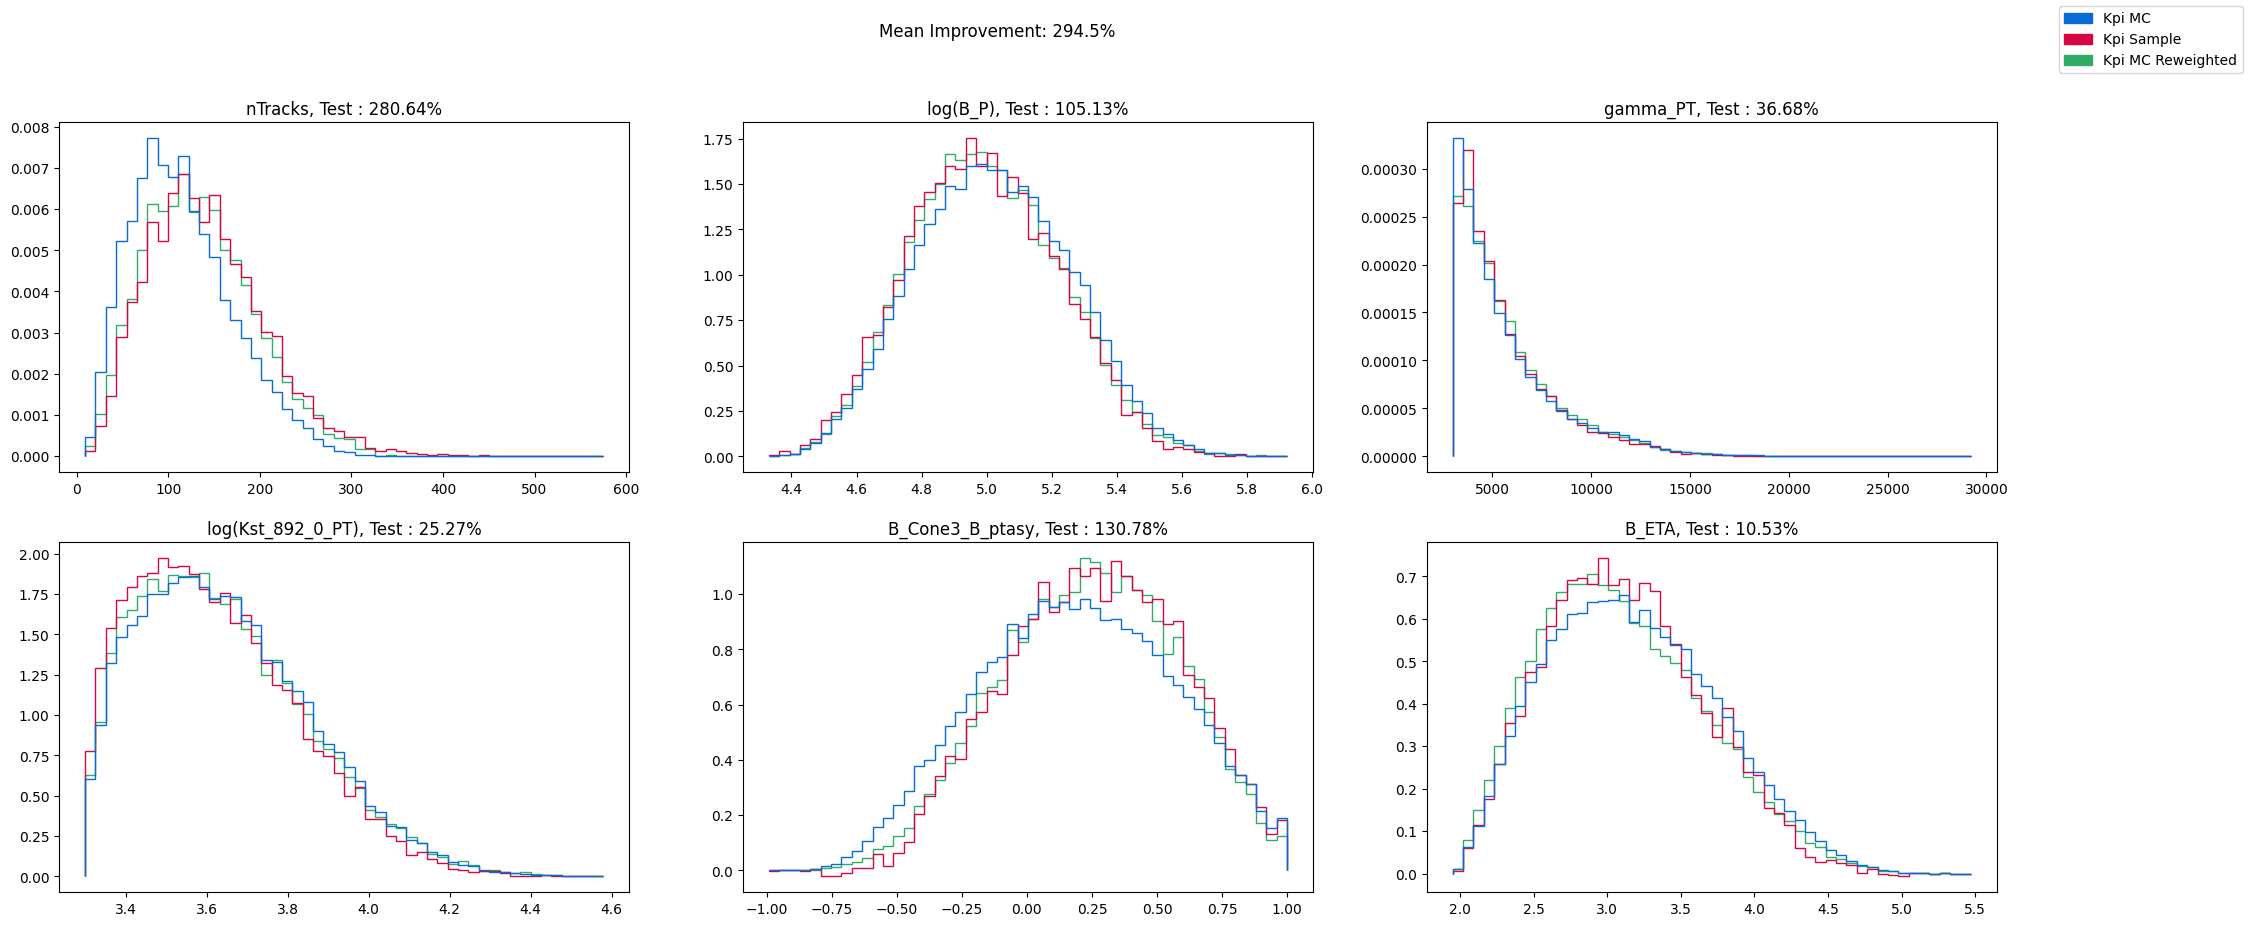

In [13]:
CreateLargeCanvasOfDoublePlots()

In [22]:

FittedWeights_RootFile = GradientBoostedReweighter.predict_weights(dataframes["pipi"][TrainingColums["pipi"]] )
Norm = len(FittedWeights_RootFile)/sum(FittedWeights_RootFile)
FittedWeights_RootFile_normalised = [ Norm*el for el in FittedWeights_RootFile]

dataframes["pipi"]["GBReweight"] = FittedWeights_RootFile_normalised
dataframes["pipi"].to_csv(path + "pipiReweight.csv")


FittedWeights_RootFile = GradientBoostedReweighter.predict_weights(dataframes["kpi"][TrainingColums["kpi"]] )
Norm = len(FittedWeights_RootFile)/sum(FittedWeights_RootFile)
FittedWeights_RootFile_normalised = [ Norm*el for el in FittedWeights_RootFile]

dataframes["kpi"]["GBReweight"] = FittedWeights_RootFile_normalised
dataframes["kpi"].to_csv(path + "kpiReweight.csv")


KFold prediction using random reweighter (length of data passed not equal to length of train)
KFold prediction using random reweighter (length of data passed not equal to length of train)


In [14]:

#Save to new root-file
import ROOT
from array import array
import itertools



decay_paths      = ["pipi",                                                                       "kpi"]
root_files       = [path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel.root",            path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel.root",]
output_filenames = [path + "pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root",  path + "kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root",]

for (root_file, output_filename, decay_path) in zip(root_files, output_filenames, decay_paths):

    input_file      = ROOT.TFile(root_file, "READ")
    input_tree      = input_file.Get("DecayTree")

    #Clone tree
    outputfile = ROOT.TFile(output_filename,"RECREATE")
    outputtree = input_tree.CloneTree(0)

    #Create branch
    newbranch = array("d", [0.0])   #storage for values that will be written to the tree later
    outputtree.Branch("GBReweight", newbranch, "GBReweight/D")

    print( f"Saving weights to {output_filename}...")

    FittedWeights_RootFile = GradientBoostedReweighter.predict_weights(dataframes[decay_path][TrainingColums[decay_path]] )
    Norm = len(FittedWeights_RootFile)/sum(FittedWeights_RootFile)
    FittedWeights_RootFile_normalised = [ Norm*el for el in FittedWeights_RootFile]


    entries = input_tree.GetEntries()

    for (i, event, weight) in zip(range(entries), input_tree, FittedWeights_RootFile_normalised):

        input_tree.GetEntry(i)
        newbranch[0] = weight

        #Fill tree
        outputtree.Fill()

    outputtree.Write()
    outputfile.Close()

    print(f"Saving weights for {output_filename} completed...")

Saving weights to /Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root...
KFold prediction using random reweighter (length of data passed not equal to length of train)
Saving weights for /Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/pipiG_MC_Bd2RhoGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root completed...
Saving weights to /Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root...
KFold prediction using random reweighter (length of data passed not equal to length of train)
Saving weights for /Users/finnjohnonori/Documents/GitHubRepositories/MScProject/data/kpiG_MC_Bd2KstGamma_HighPt_prefilter_2018_noPIDsel_gbweights.root completed...
